# Proyecto: clustering de imágenes

## Cargar librerías y datos

In [51]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import pandas as pd
import re
import tensorflow as tf
import time

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D, AveragePooling2D
from keras.optimizers import RMSprop
from keras.applications.vgg16 import VGG16
from keras import backend as K
from PIL import Image
from pandas.plotting import table
from sklearn.cluster import KMeans

In [106]:
# Importar seaborn para gráficar
import seaborn as sns
sns.set(color_codes=True, rc={'figure.figsize':(9, 6)})
sns.set_context("talk")

A continuación, se extraen los metadatos de las imágenes del dataset. Este paso tomó cierto tiempo, por lo que sólo se ejecutó una vez y el resultado se guardó en el archivo metadatos.csv. Por este motivo, las dos siguientes celdas se encuentran comentadas y simplemente se carga el resultado. 

In [32]:
'''
# Guardar metadatos de las imágenes
dir = os.listdir("../Datos/images")

filename = []
height = []
img_format = []
img_mode = []
size = []
width = []

for image in dir:
    img = Image.open("../Datos/images/" + image)
    filename.append(re.sub('../Datos/images/', '', img.filename))
    height.append(img.height)
    img_format.append(img.format)
    img_mode.append(img.mode)
    size.append(os.stat('../Datos/images/' + image).st_size / 1000.)
    width.append(img.width)
'''

'\n# Guardar metadatos de las im\xc3\xa1genes\ndir = os.listdir("../Datos/images")\n\nfilename = []\nheight = []\nimg_format = []\nimg_mode = []\nsize = []\nwidth = []\n\nfor image in dir:\n    img = Image.open("../Datos/images/" + image)\n    filename.append(re.sub(\'../Datos/images/\', \'\', img.filename))\n    height.append(img.height)\n    img_format.append(img.format)\n    img_mode.append(img.mode)\n    size.append(os.stat(\'../Datos/images/\' + image).st_size / 1000.)\n    width.append(img.width)\n'

In [33]:
'''
# Guardar metadatos como CSV
df = pd.DataFrame({'filename': filename, 'width': width, 'height': height, 'size': size, 'img_format': img_format, 'img_mode': img_mode})
df.to_csv('metadatos.csv', index=False)
df.head()
'''

"\n# Guardar metadatos como CSV\ndf = pd.DataFrame({'filename': filename, 'width': width, 'height': height, 'size': size, 'img_format': img_format, 'img_mode': img_mode})\ndf.to_csv('metadatos.csv', index=False)\ndf.head()\n"

In [3]:
# Cargar csv con metadatos
df = pd.read_csv('metadatos.csv')
df['area'] = df['height'] * df['width']
total_imgs = df.shape[0]
print("Total de imágenes: {}".format(total_imgs))
df.head()

Total de imágenes: 11131


filename  height img_format  \
0  FPEG_FEG2443_07f942c9-b700-4bff-8773-5ce637c20...     960       JPEG   
1                            3956919_2xk4enj0ulg.jpg     900       JPEG   
2                            3770755_aqm5w1u0dfn.jpg     480       JPEG   
3                     PMPI_18971_18971-1_1288858.JPG     960       JPEG   
4                            3952912_r3kk4cvbdwd.jpg     480       JPEG   

  img_mode    size  width     area  
0      RGB  77.201   1280  1228800  
1      RGB  66.236   1200  1080000  
2      RGB  51.969    640   307200  
3      RGB  24.657    470   451200  
4      RGB  27.864    640   307200

## Análisis exploratorio de datos

A continuación, se muestra un análisis estadísticos de los datos.

In [4]:
df.describe()

height          size         width          area
count  11131.000000  11131.000000  11131.000000  1.113100e+04
mean     839.124427     74.125721   1107.542000  9.696494e+05
std      181.860171     47.436370    256.681227  3.514433e+05
min      192.000000      5.334000    280.000000  5.880000e+04
25%      768.000000     39.061000    960.000000  6.912000e+05
50%      960.000000     62.885000   1280.000000  1.228800e+06
75%      960.000000     96.805000   1280.000000  1.228800e+06
max      960.000000    327.594000   1280.000000  1.228800e+06

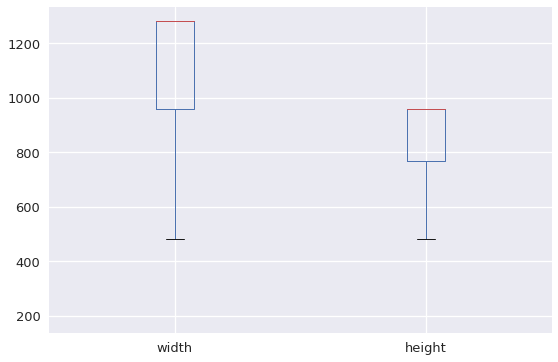

In [5]:
plt.subplots()
df.boxplot(column=['width', 'height']);

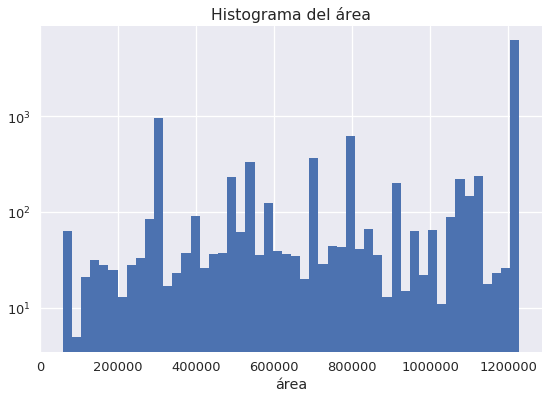

In [6]:
fig, ax = plt.subplots()
df['area'].hist(bins=50)
ax.set_title(u'Histograma del área')
ax.set_xlabel(u'área')
ax.set_yscale('log')

Estudiemos las imágenes en escala de grises:

In [7]:
df[df['img_mode'] == 'L'].count()

filename      17
height        17
img_format    17
img_mode      17
size          17
width         17
area          17
dtype: int64

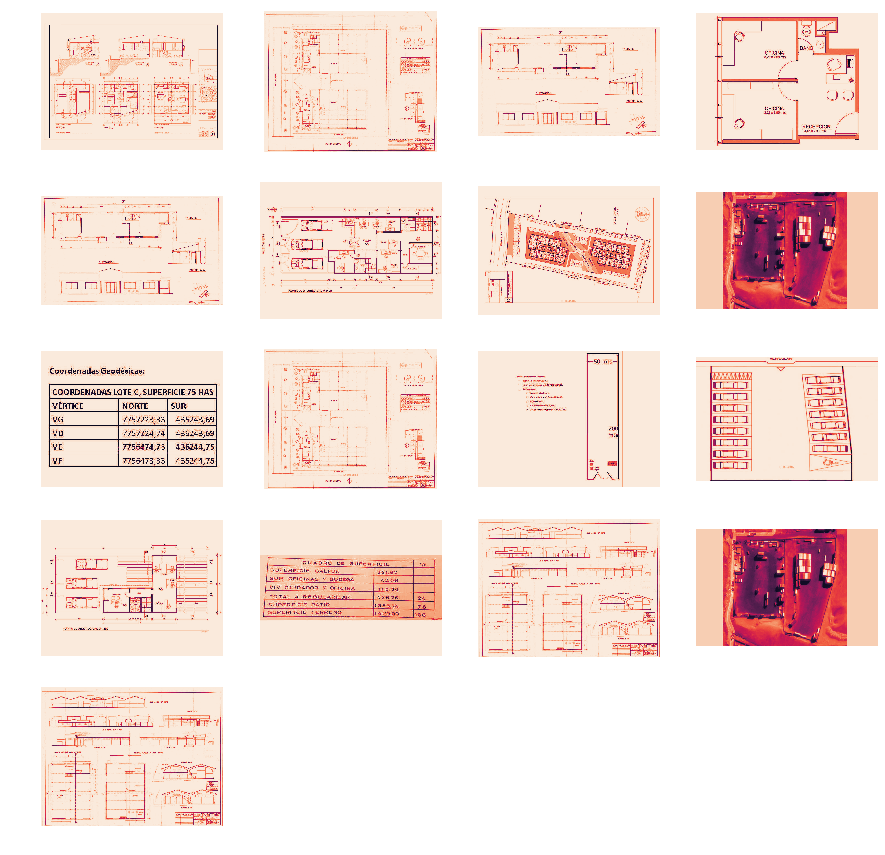

In [8]:
greyscale = list(df[df['img_mode'] == 'L'].filename)

columns = 4
images = []
for filename in greyscale:
    images.append(mpimg.imread("../Datos/images/" + filename))
    
fig, ax = plt.subplots(figsize = (15, 15))
for i, image in enumerate(images):
    plt.subplot(1.0 * len(images) / columns + 1, columns, i + 1)
    plt.axis('off')
    plt.imshow(image)

Se eliminan las imágenes en escala de grises, ya que corresponden a planos de las casas y no son relevantes para el análisis

In [9]:
df = df[df['img_mode'] != 'L']
print("Número de imágenes: {} de un total de {}".format(df.shape[0], total_imgs))

Número de imágenes: 11114 de un total de 11131


Para poder escalar las imágenes a un formato estándar, sólo se considerará aquellas que tienen un aspect ratio de 4:3.

In [10]:
df = df[(df.width > df.height) & (1.0 * df.width / df.height - 1.33333 < 0.001)]
print("Número de imágenes con aspecto 4:3 --> {} de un total de {}".format(df.shape[0], total_imgs))

Número de imágenes con aspecto 4:3 --> 9645 de un total de 11131


In [11]:
df.describe()

height         size        width          area
count  9645.000000  9645.000000  9645.000000  9.645000e+03
mean    844.218663    77.106241  1125.108657  9.945365e+05
std     183.221754    49.007827   244.178796  3.534168e+05
min     210.000000     5.334000   280.000000  5.880000e+04
25%     768.000000    40.255000  1024.000000  7.864320e+05
50%     960.000000    66.055000  1280.000000  1.228800e+06
75%     960.000000   101.450000  1280.000000  1.228800e+06
max     960.000000   327.594000  1280.000000  1.228800e+06

Analizamos las imágenes más pequeñas:

In [12]:
df_280 = df[(df.width == 280) & (df.height == 210)]
df_280.head()

filename  height img_format img_mode   size  width   area
278   3961731_ucc2y1jazib.jpg     210       JPEG      RGB  9.403    280  58800
317   3961731_5xo1obutlrk.jpg     210       JPEG      RGB  9.403    280  58800
811   3961756_m3ll0znszvq.jpg     210       JPEG      RGB  9.403    280  58800
955   3958992_swp5n5r00fv.jpg     210       JPEG      RGB  9.403    280  58800
1047  3958304_zf3fjj1w4eo.jpg     210       JPEG      RGB  9.403    280  58800

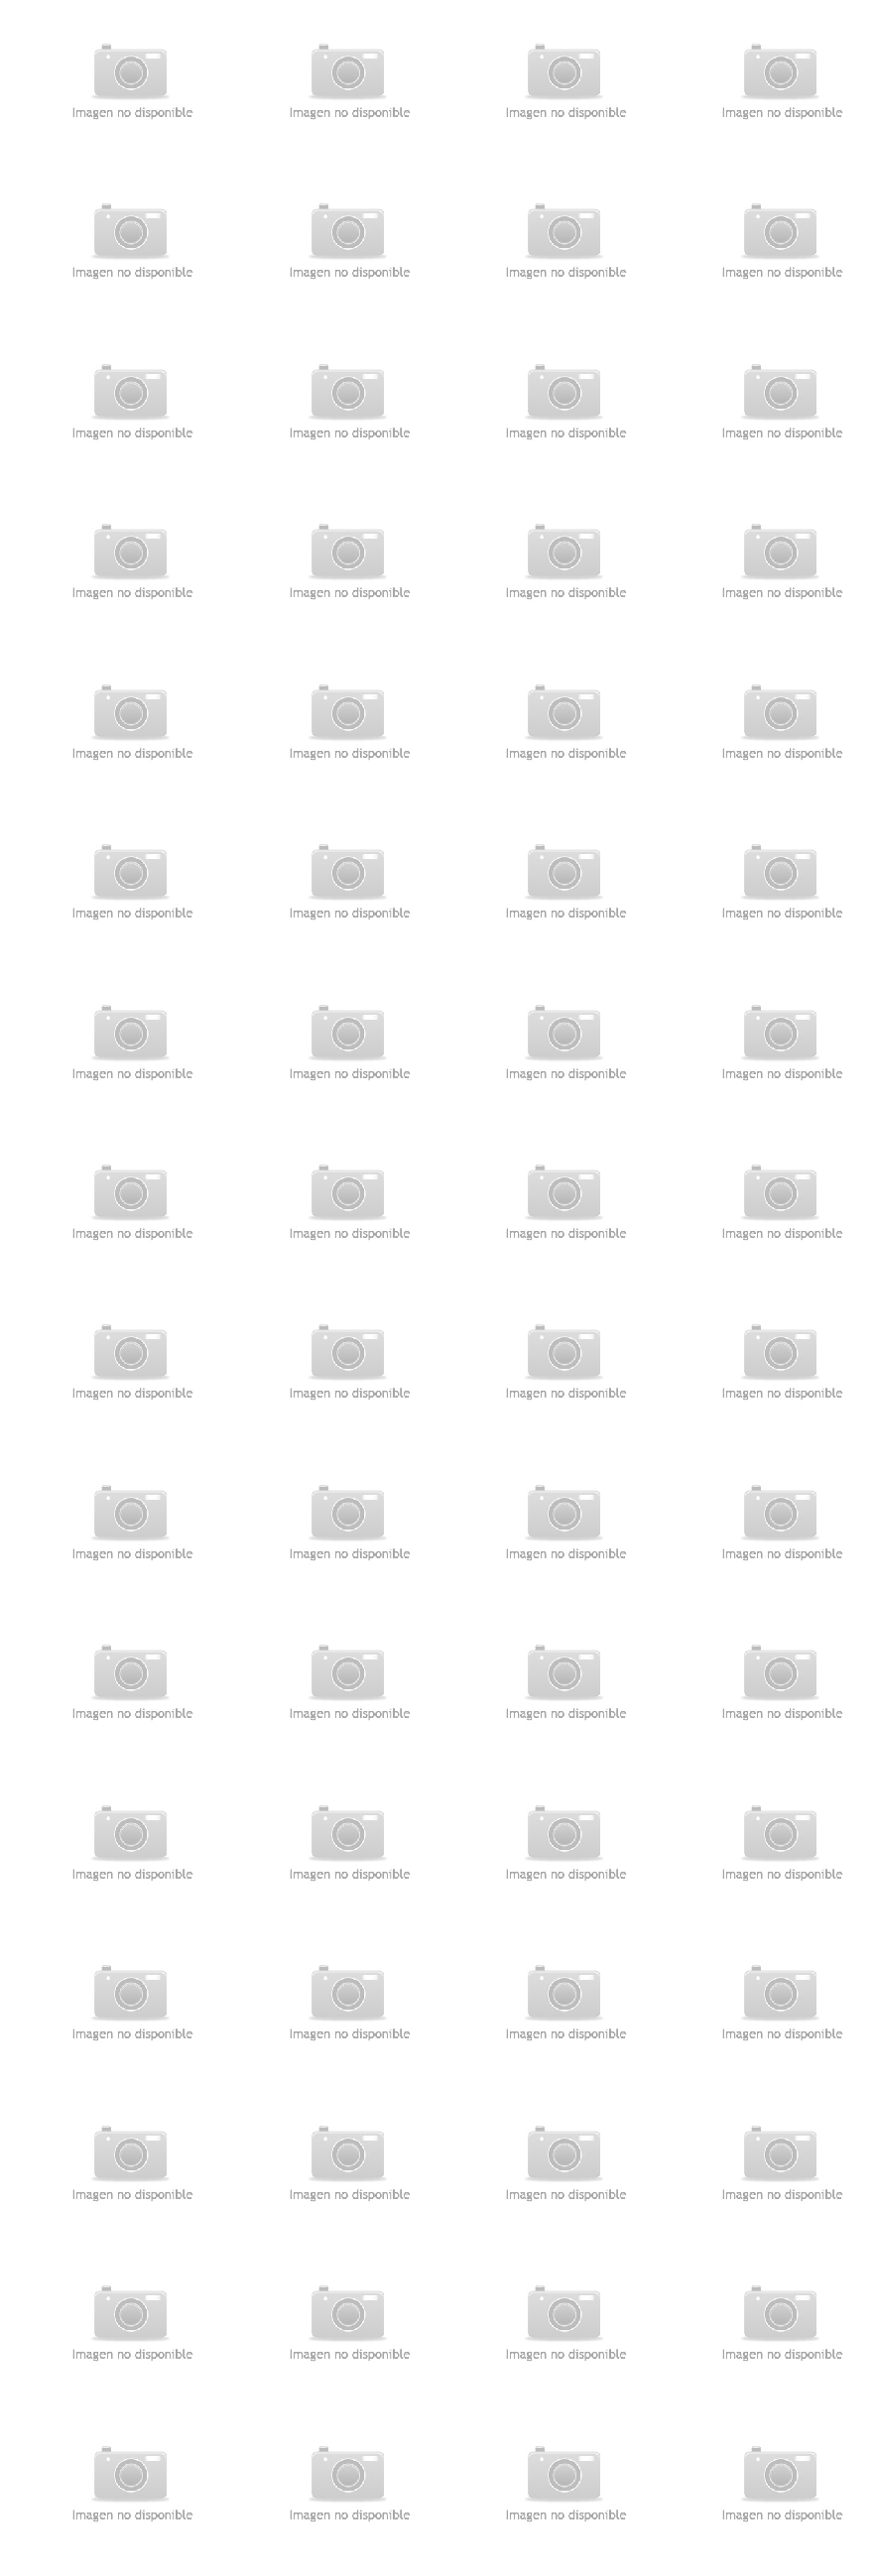

In [13]:
# Mostrar imágenes
columns = 4
images = []
for filename in df_280.filename:
    images.append(mpimg.imread("../Datos/images/" + filename))
    
fig, ax = plt.subplots(figsize = (15, 50))
for i, image in enumerate(images):
    plt.subplot(1.0 * len(images) / columns + 1, columns, i + 1)
    plt.axis('off')
    plt.imshow(image)

In [14]:
# Eliminar estas imágenes
df = df[df.width != 280]
print("Número de imágenes: {} de un total de {}".format(df.shape[0], total_imgs))

Número de imágenes: 9581 de un total de 11131


Vamos a redimensionar las imágenes a una resolución de 320x240, para reducir el costo computacional.

In [15]:
# Cargar datos y redimensionar
def process_images(df, shape=(320, 240)):
    '''
    Retorna una lista X con las imágenes normalizadas
    '''
    X = []
    # Cargar imágenes
    for filename in df.filename:
        X.append(cv2.resize(cv2.imread("../Datos/images/" + filename), shape))
    # Normalizar
    X = np.asarray(X)/255.
    
    return X

## Autoencoders

La implementación de *autoencoders* se sacó del sitio http://maxcalabro.com/clustering-images-with-autoencoders-and-attention-maps/ y se adaptó para los datos del proyecto. La siguiente función permite dividir el dataset en *batches*, ya que no se puede utilizar todos los datos a la vez en el entrenamiento debido a limitaciones de memoria.

In [16]:
def get_batches(df, batch_size=10000):
    if len(df) < batch_size:
        return [df]
    
    n_batches = len(df) // batch_size

    # If batches fit exactly into the size of df.
    if len(df) % batch_size == 0:
        return [df[i*batch_size:(i+1)*batch_size] for i in range(n_batches)]
    
    # If there is a remainder.
    else:
        return [df[i*batch_size:min((i+1)*batch_size, len(df))] for i in range(n_batches+1)]

La siguiente función lleva a cabo el entrenamiento del modelo. Recibe como input el modelo, el dataset, la cantidad de épocas, el tamaño de cada *batch* y el tamaño de la imagen (en nuestro caso, 320x240). Retorna las métricas obtenidas en el entrenamiento. 

In [17]:
def fit_auto(model, df_train, epochs=1, df_batch_size=10000, model_batch_size=128, image_size=(320, 240)):
    print('Training on {} examples.'.format(len(df_train)))
    
    # We have to run epochs one at a time -- each epoch we'll evaluate the val set.
    for i in range(epochs):
        
        print('\nStarting Epoch {} of {}.'.format(i+1, epochs))
        
        # In each epoch, we'll run the model on each of the batches.
        for batch in get_batches(df_train, df_batch_size):
            X = process_images(batch, image_size)
            model.fit(X, X,
                      batch_size=model_batch_size,
                      epochs=1,
                      verbose=1)

    score = model.evaluate(X, X, verbose=1)
    
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return score

A continuación, se define la arquitectura de la red. Esta se compone de capas convolucionales y de pooling. La función de pérdida utilizada es entropía cruzada binaria y el optimizador es *adadelta*.

In [18]:
auto_model = Sequential()

# First we'll encode the image by downsampling using Conv2D and MaxPooling layers.

auto_model.add(Conv2D(32, kernel_size=(3, 3),
               activation='relu',
               input_shape=(240, 320, 3),
               padding='same'))

auto_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
auto_model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'))
auto_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
auto_model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same'))
auto_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# Encoding finished, starting decoding, using UpSampling layers.

auto_model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same'))
auto_model.add(UpSampling2D((2, 2)))
auto_model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'))
auto_model.add(UpSampling2D((2, 2)))
auto_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
auto_model.add(UpSampling2D((2, 2)))
auto_model.add(Conv2D(3, kernel_size=(1, 1), activation='sigmoid'))

auto_model.summary()

auto_model.compile(loss='binary_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 240, 320, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 120, 160, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 160, 16)      4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 80, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 80, 8)         1160      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 40, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 40, 8)         584       
__________

Vemos que la red se compone de capas convolucionales y de pooling alternadas. Además, se muestra el tamaño del output de cada capa y la cantidad de parámetros involucrados en cada paso. El total de parámetros a aprender es 13171. La capa intermedia (que se utilizará como la representación codificada de cada imagen) es de tamaño 30x40 y tiene 8 canales.

## Ejemplo con 12 imágenes

A continuación, se muestra un ejemplo de entrenamiento de la red con 12 imágenes.

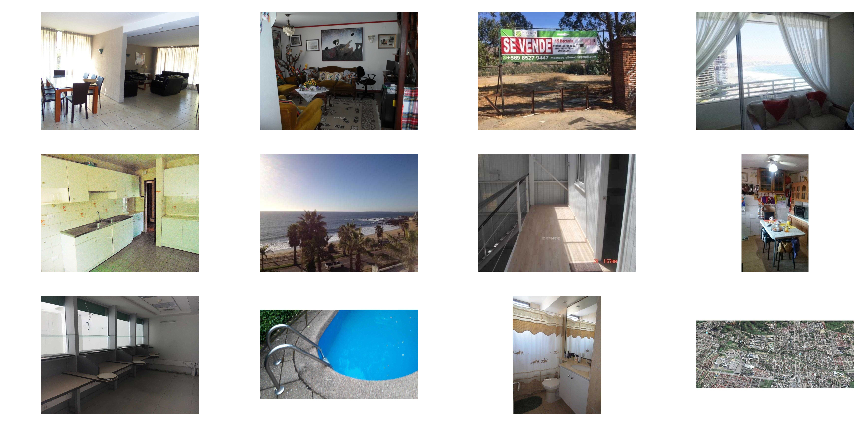

In [19]:
n = 12
df_train = df.iloc[:n, :]
img_train = process_images(df_train)

# Mostrar imágenes
fig, ax = plt.subplots(figsize = (15, 10))
for i, image in enumerate(img_train):
    plt.subplot(1.0 * len(img_train) / columns + 1, columns, i + 1)
    plt.axis('off')
    plt.imshow(image[:,:,::-1])

In [20]:
# Entrenar la red convolucional
score = fit_auto(auto_model,
                 df_train,
                 epochs=10)

Training on 12 examples.

Starting Epoch 1 of 10.
Epoch 1/1
12/12 [==============================] - 2s 170ms/step - loss: 0.6923 - acc: 0.0950

Starting Epoch 2 of 10.
Epoch 1/1
12/12 [==============================] - 1s 123ms/step - loss: 0.6895 - acc: 0.1128

Starting Epoch 3 of 10.
Epoch 1/1
12/12 [==============================] - 1s 124ms/step - loss: 0.6853 - acc: 0.1431

Starting Epoch 4 of 10.
Epoch 1/1
12/12 [==============================] - 1s 123ms/step - loss: 0.6786 - acc: 0.1443

Starting Epoch 5 of 10.
Epoch 1/1
12/12 [==============================] - 1s 122ms/step - loss: 0.6680 - acc: 0.1449

Starting Epoch 6 of 10.
Epoch 1/1
12/12 [==============================] - 2s 141ms/step - loss: 0.6568 - acc: 0.1456

Starting Epoch 7 of 10.
Epoch 1/1
12/12 [==============================] - 2s 146ms/step - loss: 0.6516 - acc: 0.1456

Starting Epoch 8 of 10.
Epoch 1/1
12/12 [==============================] - 2s 130ms/step - loss: 0.6496 - acc: 0.1456

Starting Epoch 9 of 10

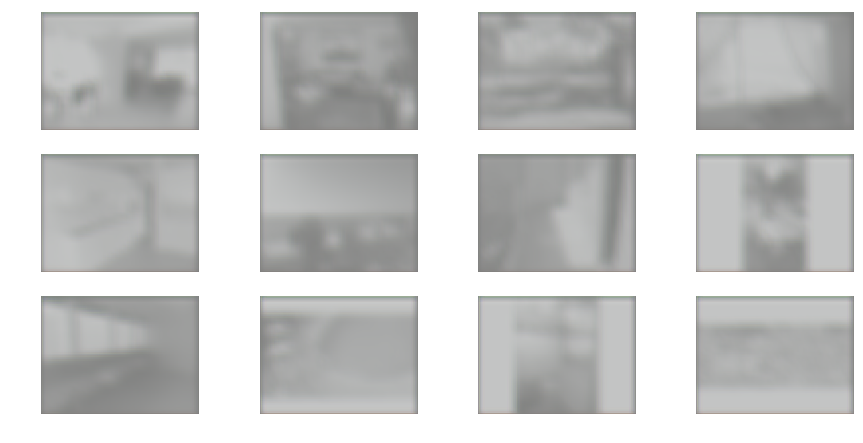

In [21]:
# Visualizar output de la red
im_decoded = auto_model.predict(img_train)

fig, ax = plt.subplots(figsize = (15, 10))
for i, image in enumerate(im_decoded):
    plt.subplot(1.0 * len(im_decoded) / columns + 1, columns, i + 1)
    plt.axis('off')
    plt.imshow(image[:,:,::-1])

Vemos que el *output* de la red es una reconstrucción de las imágenes originales, pero con información que se perdió en el proceso.

## Ejemplo con 5000 imágenes

A continuación, se ejecutó el mismo proceso con 5000 imágenes, en batches de tamaño 100 (la memoria no era suficiente para batches de mayor tamaño). Este paso tomó un tiempo considerable, por lo que sólo se ejecutó una vez. El resultado del entrenamiento se guardó en el "archivo auto_model_compressed.h5". Por este motivo, la siguiente celda se encuentra comentada y sólo se carga el modelo. 

In [25]:
'''
n = 5000
df_train = df.iloc[:n, :]

# Entrenar red
start = time.time()

score = fit_auto(auto_model,
                 df_train,
                 epochs=10,
                 df_batch_size=100)

end = time.time()

print("Tiempo de entrenamiento: {} minutos".format((end - start) / 60))

# Guardar el modelo
auto_model.save('auto_model_compressed.h5')
'''

Training on 5000 examples.

Starting Epoch 1 of 10.
Epoch 1/1
100/100 [==============================] - 18s 180ms/step - loss: 0.6888 - acc: 0.0750
Epoch 1/1
100/100 [==============================] - 17s 171ms/step - loss: 0.6436 - acc: 0.1357
Epoch 1/1
100/100 [==============================] - 13s 131ms/step - loss: 0.6169 - acc: 0.1376
Epoch 1/1
100/100 [==============================] - 13s 126ms/step - loss: 0.5870 - acc: 0.1849
Epoch 1/1
100/100 [==============================] - 17s 172ms/step - loss: 0.5896 - acc: 0.1532
Epoch 1/1
100/100 [==============================] - 13s 133ms/step - loss: 0.5659 - acc: 0.1953
Epoch 1/1
100/100 [==============================] - 23s 233ms/step - loss: 0.5726 - acc: 0.1524
Epoch 1/1
100/100 [==============================] - 38s 377ms/step - loss: 0.6227 - acc: 0.1300
Epoch 1/1
100/100 [==============================] - 13s 134ms/step - loss: 0.7653 - acc: 0.0053
Epoch 1/1
100/100 [==============================] - 12s 125ms/step - loss:

Epoch 1/1
100/100 [==============================] - 12s 122ms/step - loss: 0.5287 - acc: 0.1896
Epoch 1/1
100/100 [==============================] - 12s 122ms/step - loss: 0.5393 - acc: 0.1386
Epoch 1/1
100/100 [==============================] - 12s 122ms/step - loss: 0.5139 - acc: 0.1794
Epoch 1/1
100/100 [==============================] - 12s 121ms/step - loss: 0.5302 - acc: 0.1396
Epoch 1/1
100/100 [==============================] - 12s 122ms/step - loss: 0.5330 - acc: 0.1510
Epoch 1/1
100/100 [==============================] - 12s 121ms/step - loss: 0.5128 - acc: 0.1513
Epoch 1/1
100/100 [==============================] - 12s 122ms/step - loss: 0.5071 - acc: 0.1648
Epoch 1/1
100/100 [==============================] - 12s 122ms/step - loss: 0.5233 - acc: 0.1502
Epoch 1/1
100/100 [==============================] - 12s 121ms/step - loss: 0.4978 - acc: 0.1805
Epoch 1/1
100/100 [==============================] - 12s 121ms/step - loss: 0.4966 - acc: 0.1798
Epoch 1/1
100/100 [===========

Epoch 1/1
100/100 [==============================] - 12s 122ms/step - loss: 0.5100 - acc: 0.1631
Epoch 1/1
100/100 [==============================] - 12s 123ms/step - loss: 0.5020 - acc: 0.1740
Epoch 1/1
100/100 [==============================] - 12s 122ms/step - loss: 0.5117 - acc: 0.1543
Epoch 1/1
100/100 [==============================] - 12s 121ms/step - loss: 0.4825 - acc: 0.2078
Epoch 1/1
100/100 [==============================] - 12s 123ms/step - loss: 0.5355 - acc: 0.1412
Epoch 1/1
100/100 [==============================] - 12s 121ms/step - loss: 0.5490 - acc: 0.1835
Epoch 1/1
100/100 [==============================] - 12s 120ms/step - loss: 0.5546 - acc: 0.1734
Epoch 1/1
100/100 [==============================] - 12s 122ms/step - loss: 0.5311 - acc: 0.2044
Epoch 1/1
100/100 [==============================] - 12s 121ms/step - loss: 0.5113 - acc: 0.1649
Epoch 1/1
100/100 [==============================] - 12s 121ms/step - loss: 0.5026 - acc: 0.1561
Epoch 1/1
100/100 [===========

Epoch 1/1
100/100 [==============================] - 12s 122ms/step - loss: 0.5193 - acc: 0.1377
Epoch 1/1
100/100 [==============================] - 12s 123ms/step - loss: 0.4957 - acc: 0.1851
Epoch 1/1
100/100 [==============================] - 12s 121ms/step - loss: 0.5169 - acc: 0.1535
Epoch 1/1
100/100 [==============================] - 12s 121ms/step - loss: 0.4993 - acc: 0.1952
Epoch 1/1
100/100 [==============================] - 12s 122ms/step - loss: 0.5251 - acc: 0.1525
Epoch 1/1
100/100 [==============================] - 12s 122ms/step - loss: 0.5388 - acc: 0.1306
Epoch 1/1
100/100 [==============================] - 12s 122ms/step - loss: 0.5003 - acc: 0.1950
Epoch 1/1
100/100 [==============================] - 12s 122ms/step - loss: 0.4952 - acc: 0.1825
Epoch 1/1
100/100 [==============================] - 12s 122ms/step - loss: 0.4982 - acc: 0.1647
Epoch 1/1
100/100 [==============================] - 12s 122ms/step - loss: 0.5120 - acc: 0.1314
Epoch 1/1
100/100 [===========

Epoch 1/1
100/100 [==============================] - 12s 122ms/step - loss: 0.5126 - acc: 0.1396
Epoch 1/1
100/100 [==============================] - 12s 122ms/step - loss: 0.5133 - acc: 0.1512
Epoch 1/1
100/100 [==============================] - 12s 121ms/step - loss: 0.4930 - acc: 0.1513
Epoch 1/1
100/100 [==============================] - 12s 122ms/step - loss: 0.4864 - acc: 0.1649
Epoch 1/1
100/100 [==============================] - 12s 121ms/step - loss: 0.5053 - acc: 0.1502
Epoch 1/1
100/100 [==============================] - 12s 122ms/step - loss: 0.4806 - acc: 0.1806
Epoch 1/1
100/100 [==============================] - 12s 123ms/step - loss: 0.4862 - acc: 0.1798
Epoch 1/1
100/100 [==============================] - 12s 122ms/step - loss: 0.5004 - acc: 0.1882
Epoch 1/1
100/100 [==============================] - 12s 121ms/step - loss: 0.5204 - acc: 0.1434
Epoch 1/1
100/100 [==============================] - 12s 121ms/step - loss: 0.5014 - acc: 0.1577
Epoch 1/1
100/100 [===========

Epoch 1/1
100/100 [==============================] - 12s 122ms/step - loss: 0.4631 - acc: 0.2080
Epoch 1/1
100/100 [==============================] - 12s 123ms/step - loss: 0.5036 - acc: 0.1413
Epoch 1/1
100/100 [==============================] - 12s 123ms/step - loss: 0.4870 - acc: 0.1846
Epoch 1/1
100/100 [==============================] - 12s 122ms/step - loss: 0.5034 - acc: 0.1734
Epoch 1/1
100/100 [==============================] - 12s 121ms/step - loss: 0.4931 - acc: 0.2051
Epoch 1/1
100/100 [==============================] - 12s 120ms/step - loss: 0.5213 - acc: 0.1649
Epoch 1/1
100/100 [==============================] - 12s 121ms/step - loss: 0.5188 - acc: 0.1559
Epoch 1/1
100/100 [==============================] - 12s 121ms/step - loss: 0.4922 - acc: 0.1944
Epoch 1/1
100/100 [==============================] - 12s 122ms/step - loss: 0.4668 - acc: 0.2269
Epoch 1/1
100/100 [==============================] - 12s 123ms/step - loss: 0.5005 - acc: 0.1614
Epoch 1/1
100/100 [===========

Tiempo de entrenamiento: 129.207549131 minutos

La red sólo logró una precisión de 0.16. Sin embargo, más que la precisión en la reconstrucción de las imágenes, lo que buscamos es que la red sea capaz de codificarlas de tal forma que las imágenes similares queden en un mismo cluster.

El siguiente paso corresponde a pasar las imágenes a través de la primera etapa de la red, de forma de obtener la versión codificada. Nuevamente, como este paso tomó un tiempo considerable, sólo se carga el resultado.

In [39]:
'''
# Cargar modelo
auto_model = load_model("auto_model_compressed.h5")

# Función de codificación
get_encoded = K.function([auto_model.layers[0].input],
                     [auto_model.layers[5].output])

# Pasar los datos a través de las primeras capas de la red
df_train = df.iloc[:5000, :]
X_encoded = []
i=0
for batch in get_batches(df_train, batch_size=100):
    i+=1
    print('Running batch... {}'.format(i*len(batch)))    
    X_encoded.append(get_encoded([process_images(batch)])[0])

X_encoded = np.concatenate(X_encoded)

# Guardar resultado
np.save('images_compressed.npy', X_encoded)
'''

Running batch... 100
Running batch... 200
Running batch... 300
Running batch... 400
Running batch... 500
Running batch... 600
Running batch... 700
Running batch... 800
Running batch... 900
Running batch... 1000
Running batch... 1100
Running batch... 1200
Running batch... 1300
Running batch... 1400
Running batch... 1500
Running batch... 1600
Running batch... 1700
Running batch... 1800
Running batch... 1900
Running batch... 2000
Running batch... 2100
Running batch... 2200
Running batch... 2300
Running batch... 2400
Running batch... 2500
Running batch... 2600
Running batch... 2700
Running batch... 2800
Running batch... 2900
Running batch... 3000
Running batch... 3100
Running batch... 3200
Running batch... 3300
Running batch... 3400
Running batch... 3500
Running batch... 3600
Running batch... 3700
Running batch... 3800
Running batch... 3900
Running batch... 4000
Running batch... 4100
Running batch... 4200
Running batch... 4300
Running batch... 4400
Running batch... 4500
Running batch... 46

In [43]:
# Cargar imágenes comprimidas
X_encoded = np.load('images_compressed.npy')
X_encoded.shape

(5000, 30, 40, 8)

Vemos que el resultado de la codificación es un arreglo con 5000 imágenes, de tamaño 40x30 y con 8 canales. Para poder llevar a cabo el clustering con k-means, se debe redimensionar este vector de forma que cada imagen quede representada por un vector plano de dimensiones $30x40x8 = 9600$

In [50]:
# Redimensionar vector para aplicar k-means
X_encoded = X_encoded.reshape(X_encoded.shape[0], X_encoded.shape[1] * X_encoded.shape[2] * X_encoded.shape[3])
X_encoded.shape

(5000, 9600)

## Clustering

A continuación, se aplica k-means sobre los datos, con k=20. Se eligió este valor ya que se consideró que es un número razonable de grupos para encontrar características similares, además de que el algoritmo no toma mucho tiempo (en comparación con valores más altos de k).

In [52]:
kmeans = KMeans(n_clusters=20, random_state=0).fit(X_encoded)

In [61]:
# Agregamos el resultado del clustering como una columna del dataset usado para el entrenamiento
df_train['cluster'] = kmeans.labels_
df_train.head()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


filename  height img_format  \
0  FPEG_FEG2443_07f942c9-b700-4bff-8773-5ce637c20...     960       JPEG   
1                            3956919_2xk4enj0ulg.jpg     900       JPEG   
2                            3770755_aqm5w1u0dfn.jpg     480       JPEG   
4                            3952912_r3kk4cvbdwd.jpg     480       JPEG   
6                            3956367_scrvonqspg2.jpg     960       JPEG   

  img_mode     size  width     area  cluster  
0      RGB   77.201   1280  1228800        2  
1      RGB   66.236   1200  1080000       12  
2      RGB   51.969    640   307200       12  
4      RGB   27.864    640   307200       15  
6      RGB  138.254   1280  1228800        2

Veamos la distribución de los clusters:

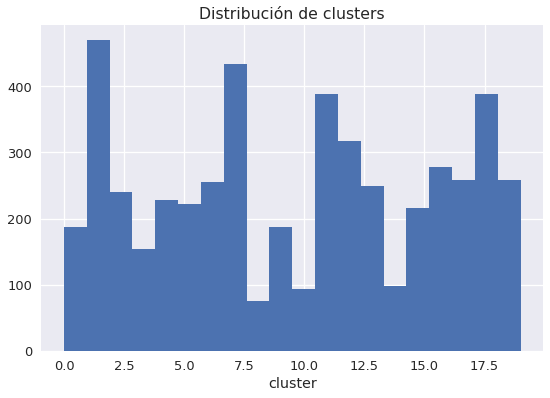

In [65]:
fig, ax = plt.subplots()
df_train['cluster'].hist(bins=20)
ax.set_title(u'Distribución de clusters')
ax.set_xlabel(u'cluster');

El siguiente código muestra 5 imágenes de ejemplo de cada cluster, escogidas al azar:

In [171]:
# Graficar imágenes aleatorias de un cluster
sns.set_style("whitegrid", {'axes.grid' : False})
def plot_all_clusters(df, n_cluster, n_samples, seed=0):
    np.random.seed(seed=seed)
    fig, ax = plt.subplots(figsize = (15, 10))
    df_cluster = df[df.cluster == n_cluster]
    img_idx = np.random.randint(df_cluster.shape[0], size=n_samples)
    imgs_cluster = process_images(df_cluster.iloc[img_idx])
    columns = n_samples
    
    for i, image in enumerate(imgs_cluster):
        plt.subplot(1.0 * len(imgs_cluster) / columns + 1, columns, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.ylabel('cluster {}'.format(n_cluster))
        plt.imshow(image[:,:,::-1]);

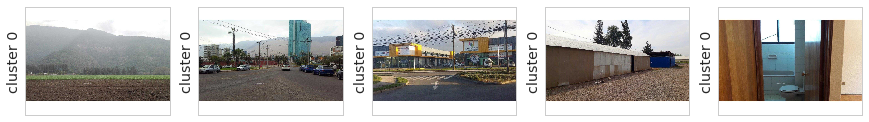

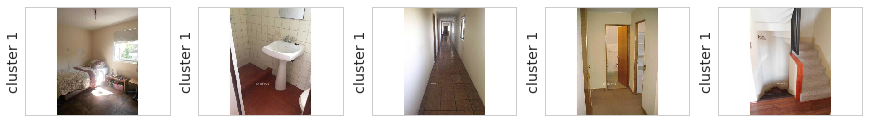

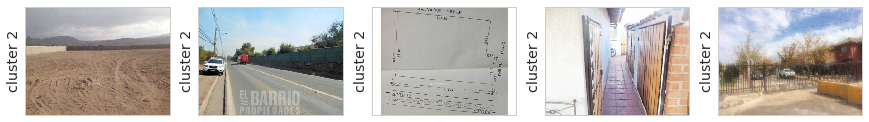

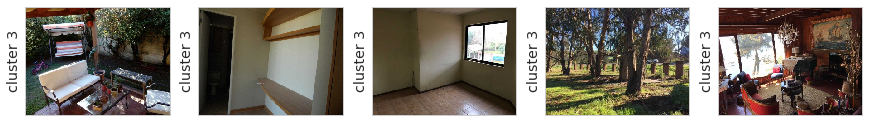

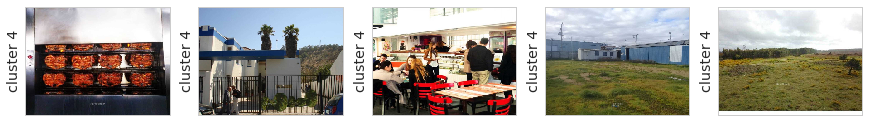

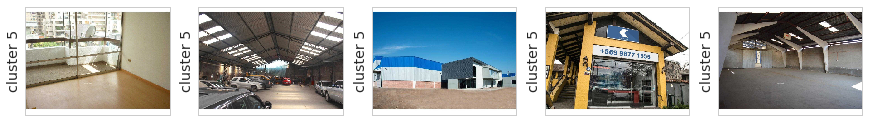

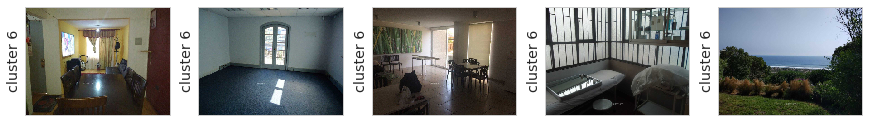

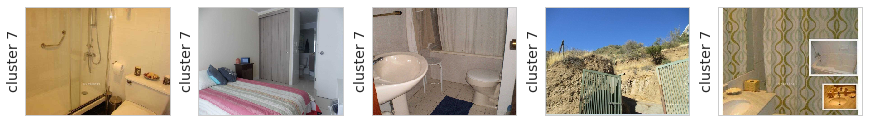

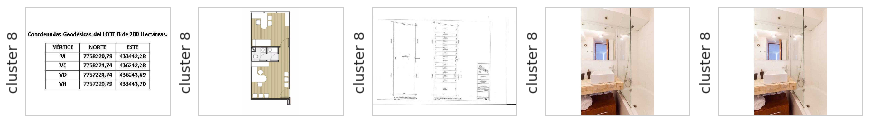

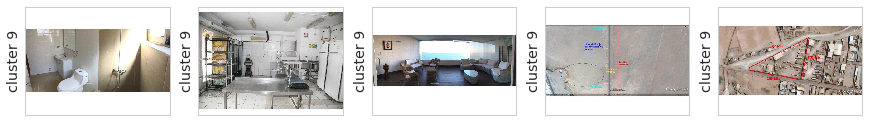

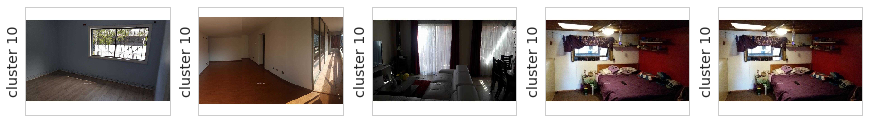

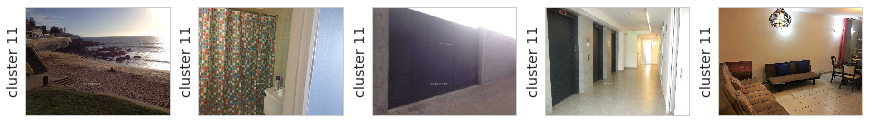

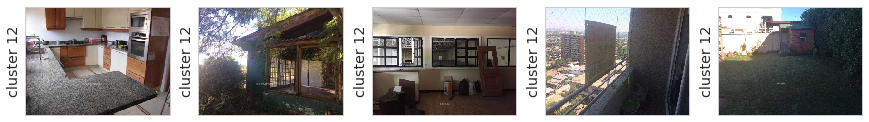

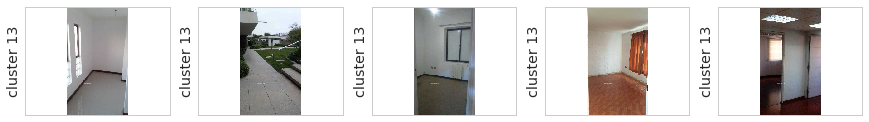

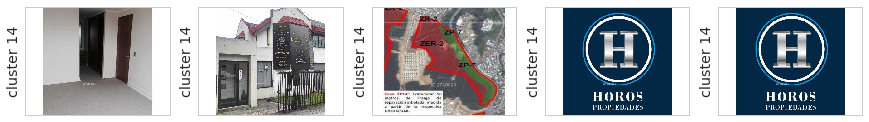

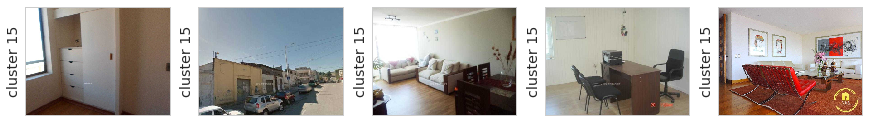

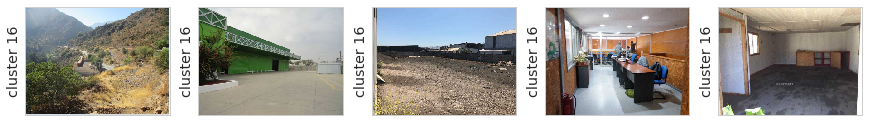

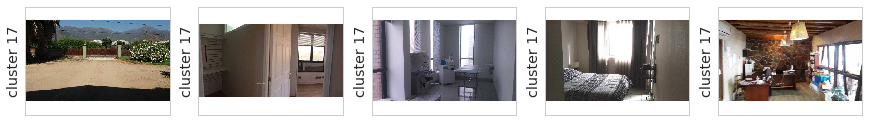

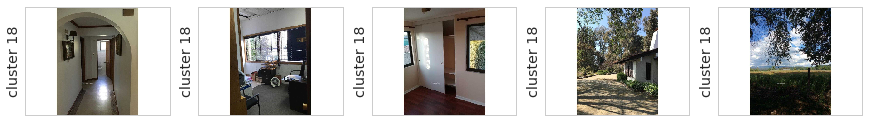

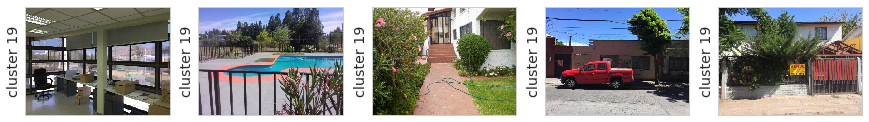

In [172]:
for cluster_idx in range(20):
    plot_all_clusters(df_train, n_cluster=cluster_idx, n_samples=5)

Llama la atención el cluster 8, ya que 3 de las 5 imágenes corresponden planos y una tabla. Analicemos el cluster en profundidad:

In [173]:
# Mostrar todas las imágenes de un cluster
def plot_cluster(n_cluster, columns=10):
    images = process_images(df_train[df_train.cluster == n_cluster])
    print("Tamaño del cluster: {}".format(len(images)))

    fig, ax = plt.subplots(figsize = (20, 3*len(images) / columns))
    for i, image in enumerate(images):
        plt.subplot(1.0 * len(images) / columns + 1, columns, i + 1)
        plt.axis('off')
        plt.imshow(image[:,:,::-1])

Tamaño del cluster: 75


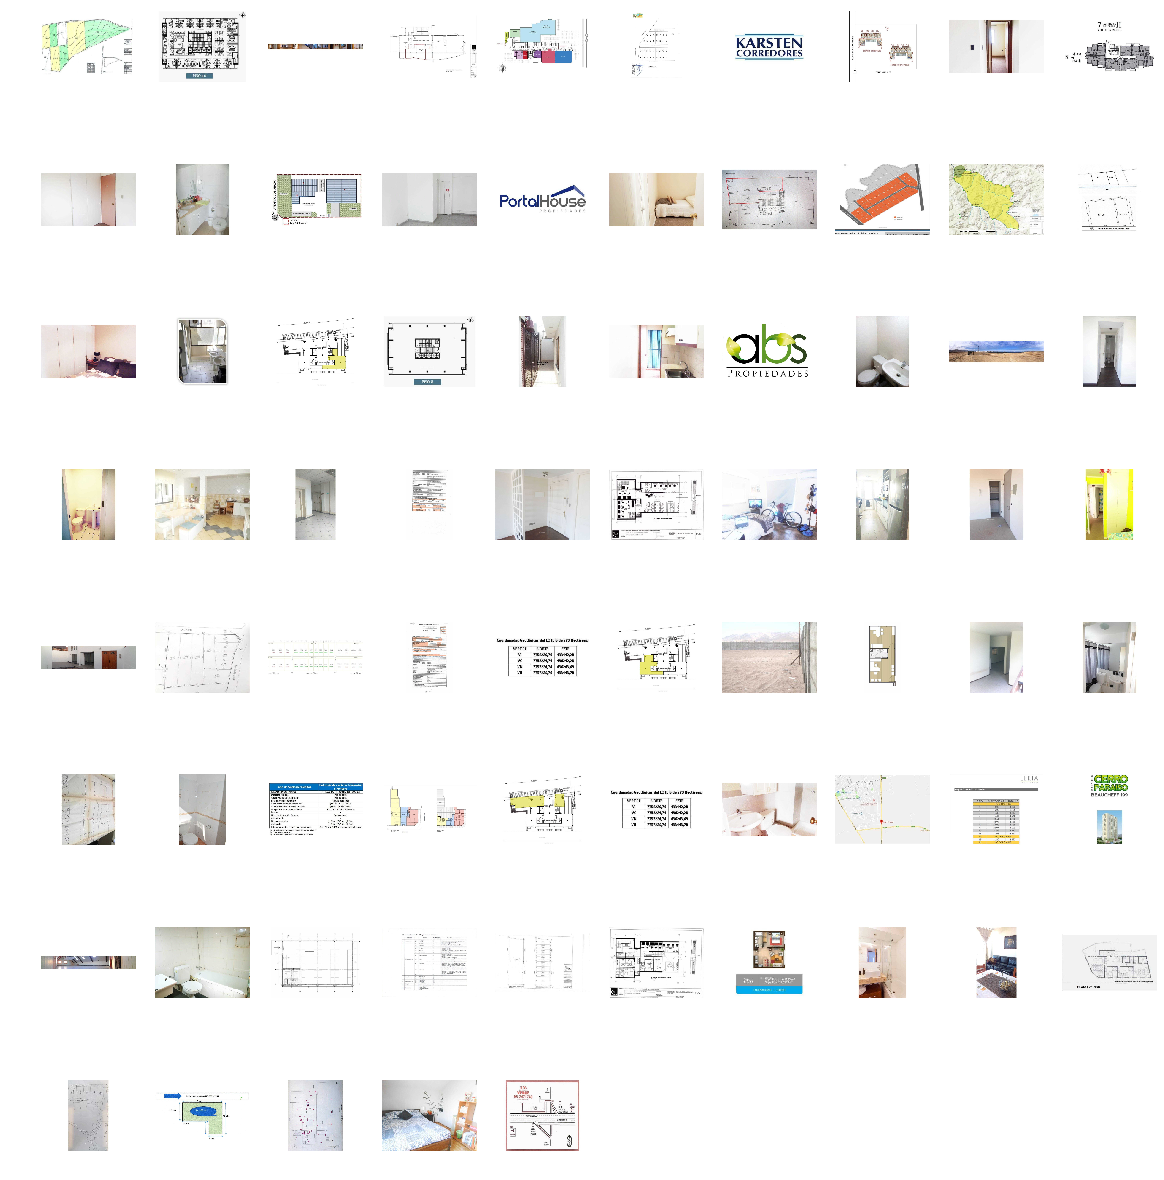

In [174]:
plot_cluster(n_cluster=8)

Efectivamente, podemos ver que la mayor parte de las imágenes del cluster 8 corresponden a planos, logos de empresas y tablas, todos los cuales tienen en común que su fondo es blanco. Estas imágenes pueden ser descartadas para un análisis posterior.

Estudiemos ahora el cluster 0:

Tamaño del cluster: 187


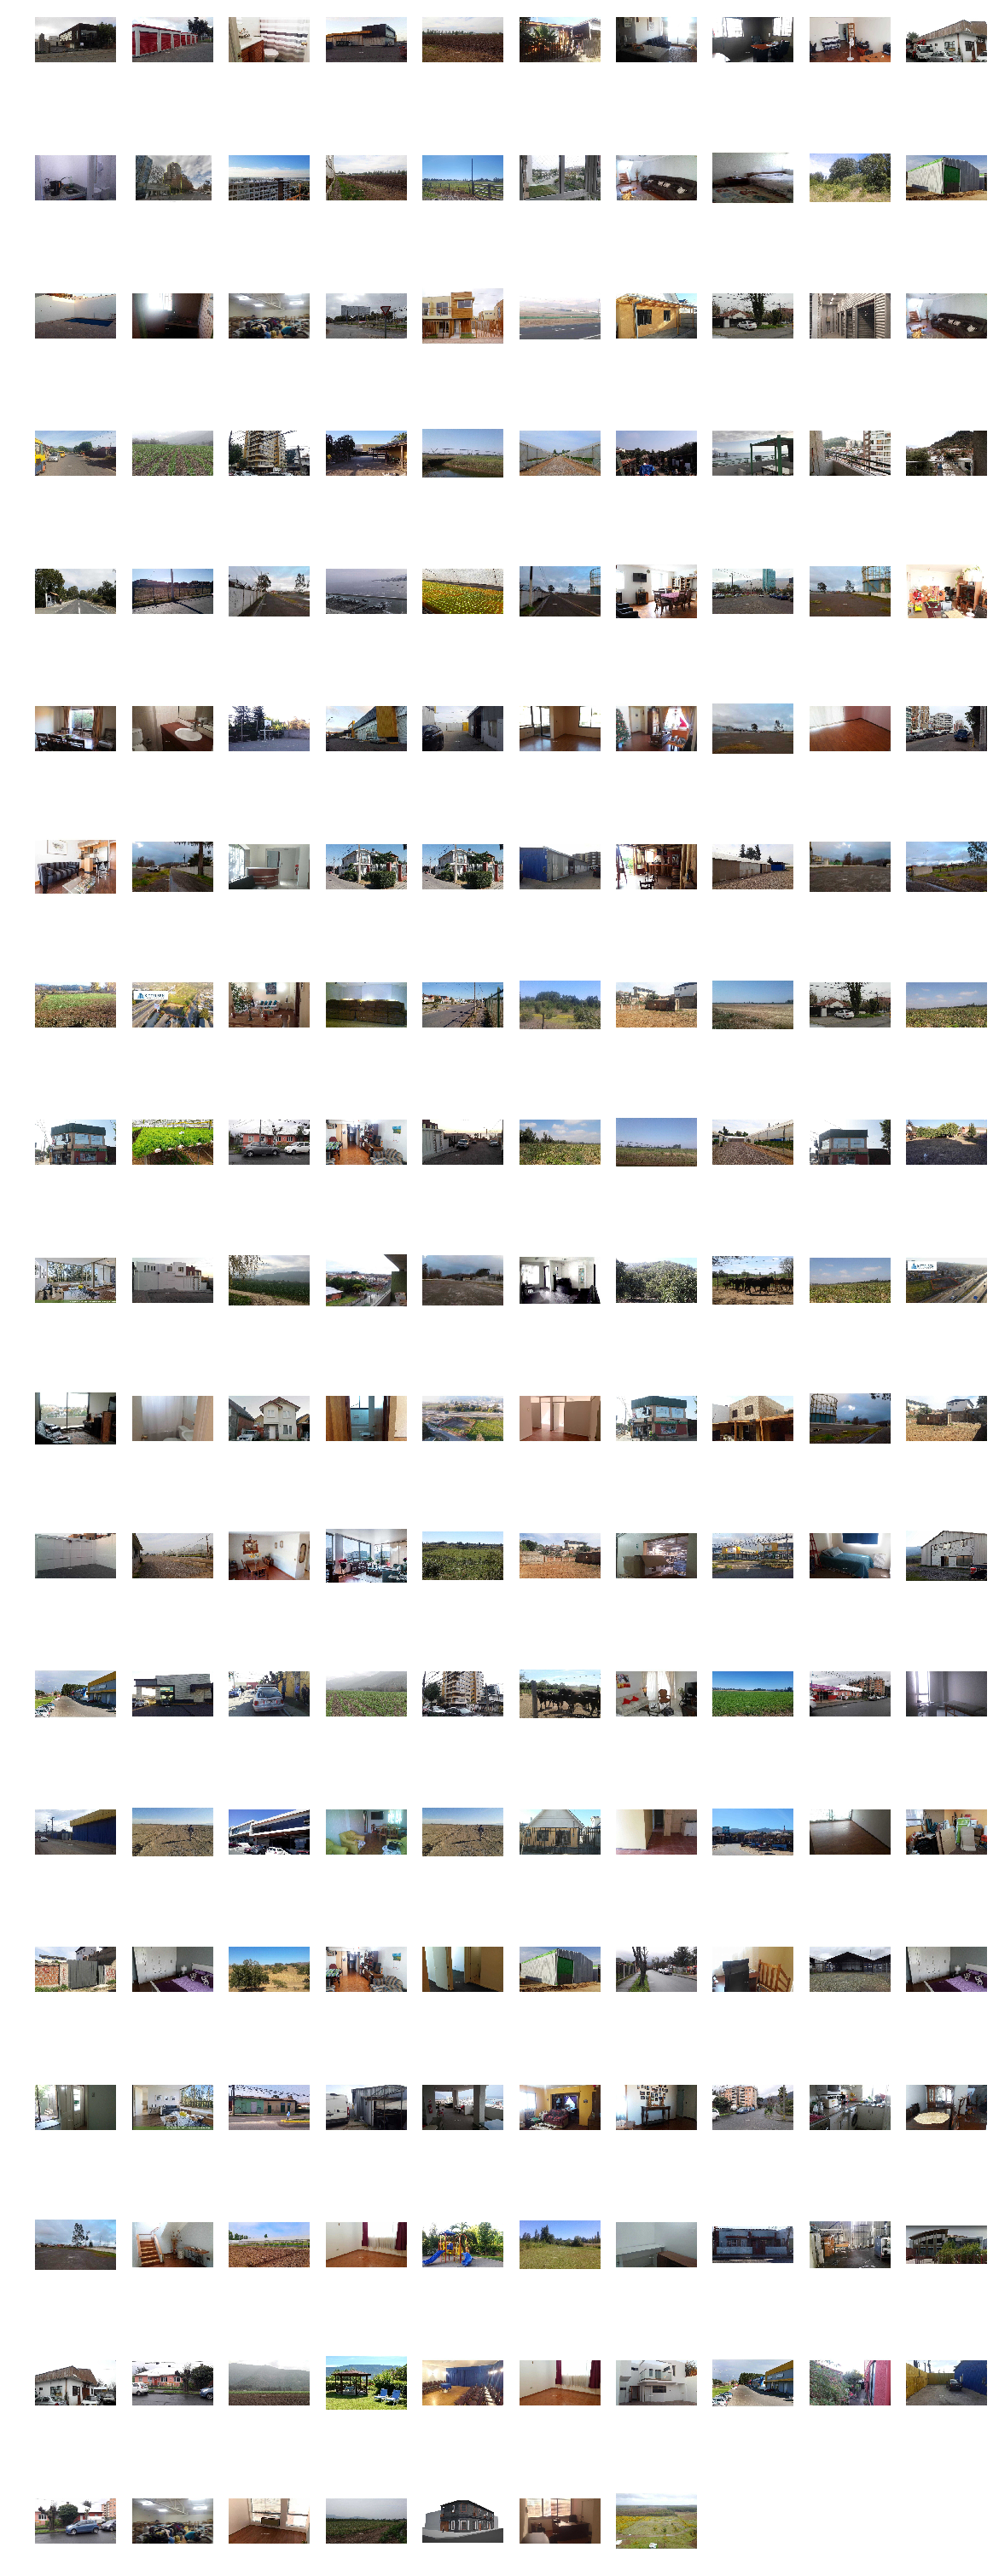

In [176]:
plot_cluster(n_cluster=0)

Se puede ver que gran parte de la imágenes corresponde a fotos de terrenos. A futuro, se planea volver a hacer clustering dentro del cluster 0 para agrupar estas imágenes y descartarlas.